Импортируем необходимые библиотеки

In [342]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

Получим данные

In [343]:
data = pd.read_csv("../jupyter/data/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Проанализируем наши данные

In [344]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [345]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [346]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Предобработаем данные

Преобразуем не числовые категориальные признаки в числовые

In [347]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'] = data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [348]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0


Также при анализе данных мы увидели, что у нас есть отстутствующие значения в столбцах `Age`, `Cabin` и `Embarked`

 Логично выбрать столбцы Pclass и Sex для обработки пропусков, потому что это одни из самых значимых признаков для нашего предсказания Survived

In [349]:
# Заполнение пропусков в Age медианой.
data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [350]:
# Заполнение пропусков в 'Embarked' модой
embarked_imputer = SimpleImputer(strategy='most_frequent')
data['Embarked'] = embarked_imputer.fit_transform(data[['Embarked']]).flatten()

In [351]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Подробный анализ и визуализация данных были реализованы в файле `../jupyter/jupyter.ipynb`

Создадим новые признаки (возможно, это улучшит качество наших моделей)
<br>Спойлер: улучшит еще как

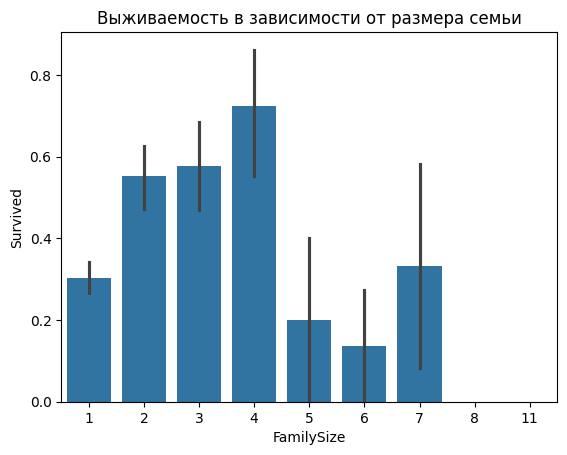

In [352]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

sns.barplot(data=data, x='FamilySize', y='Survived')
plt.title("Выживаемость в зависимости от размера семьи")
plt.show()

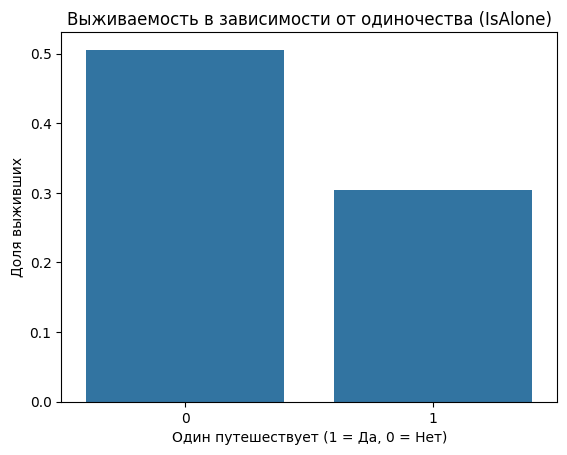

In [353]:
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

sns.barplot(data=data, x='IsAlone', y='Survived', errorbar=None)
plt.title("Выживаемость в зависимости от одиночества (IsAlone)")
plt.xlabel("Один путешествует (1 = Да, 0 = Нет)")
plt.ylabel("Доля выживших")
plt.show()

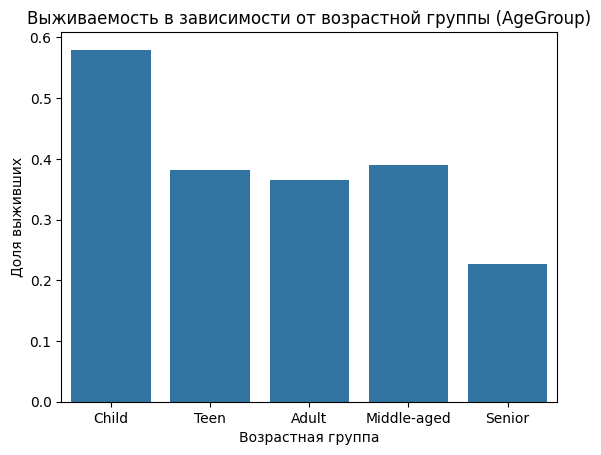

In [354]:
data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 20, 40, 60, 80], labels=['Child', 'Teen', 'Adult', 'Middle-aged', 'Senior'])

sns.barplot(data=data, x='AgeGroup', y='Survived', errorbar=None)
plt.title("Выживаемость в зависимости от возрастной группы (AgeGroup)")
plt.xlabel("Возрастная группа")
plt.ylabel("Доля выживших")
plt.show()


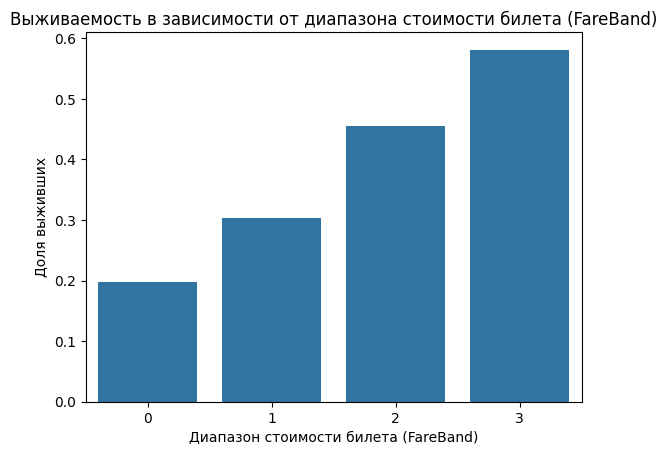

In [355]:
data['FareBand'] = pd.qcut(data['Fare'], 4, labels=[0, 1, 2, 3])

sns.barplot(data=data, x='FareBand', y='Survived', errorbar=None)
plt.title("Выживаемость в зависимости от диапазона стоимости билета (FareBand)")
plt.xlabel("Диапазон стоимости билета (FareBand)")
plt.ylabel("Доля выживших")
plt.show()


In [356]:
data['LastName'] = data['Name'].apply(lambda x: x.split(',')[0])
family_survival = data.groupby('LastName')['Survived'].transform('mean')
data['FamilySurvivalRate'] = family_survival.fillna(0)

Удалим признаки, которые исходя из логики не влияют на то, выжил человек или нет.

In [357]:
data.drop(['Cabin', 'Name', 'Ticket', 'PassengerId', 'LastName'], axis=1, inplace=True)

Применим OneHotEncoder для полученных категориальных признаков

In [358]:
# OneHotEncoder с drop_first для предотвращения мультиколлинеарности
data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'AgeGroup', 'FareBand'], drop_first=True)

Еще раз посмотрим на данные, нужно ли нам масштабировать выборку?

- Survived: 0 или 1 (целевой признак)
<br>
<br>
- Pclass: 1, 2, 3 (категориальный признак)
- Sex: мужской/женский (категориальный признак)
- Embarked: порт посадки (категориальный признак)
<br>
<br>
- Name: строка (не используется в обучении)
- Ticket: строка (не используется в обучении)
- Cabin: строка (не используется в обучении)
<br>
<br>
- Age: числовой признак (возраст пассажира)
- SibSp: количество братьев/сестёр на борту
- Parch: количество родителей/детей на борту
- Fare: стоимость билета
- FamilySize: Размер семьи

Чиловые признаки имеют разные диапазоны значений. Например, `Fare` может иметь большие значения, а `Age` — меньшие. Это может привести к дисбалансу в влиянии признаков на модель, если используется модель, чувствительная к масштабу (RandomForest и DecisionTree не чувствительны к масштабу данных, в отличие от линейной и логистической регрессии)

In [359]:
# Масштабируем только числовые признаки
scaler = StandardScaler()
data[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']] = scaler.fit_transform(data[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']])

Задача - получить значения метрик лучше, чем:
- Для `DecisionTreeClassifier`
  - `precision` для выживших --- 0.79
  - `recall` для выживших --- 0.72
  - `f1_score` для выживших --- 0.75
- Для `RandomForestClassifier`
  - `accuracy` --- 0.8
- Для `LogisticRegression`
  - `precision` для погибших --- 0.81
  - `recall` для погибших --- 0.88
- Для `LinearRegression`
  - `RootMeanSquaredError` для возраста пассажиров --- 10.7

In [360]:
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FamilySurvivalRate,Sex_1,Embarked_1.0,Embarked_2.0,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Middle-aged,AgeGroup_Senior,FareBand_1,FareBand_2,FareBand_3
0,0,3,-0.534891,0.432793,-0.473674,-0.502445,0.059160,0,0.0,False,False,True,False,True,False,False,False,False,False
1,1,1,0.668392,0.432793,-0.473674,0.786845,0.059160,0,1.0,True,False,False,False,True,False,False,False,False,True
2,1,3,-0.234070,-0.474545,-0.473674,-0.488854,-0.560975,1,1.0,True,False,True,False,True,False,False,True,False,False
3,1,1,0.442776,0.432793,-0.473674,0.420730,0.059160,0,0.5,True,False,True,False,True,False,False,False,False,True
4,0,3,0.442776,-0.474545,-0.473674,-0.486337,-0.560975,1,0.5,False,False,True,False,True,False,False,True,False,False


In [361]:
# Разделение данных
X = data.drop('Survived', axis=1)
y = data['Survived']

X

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FamilySurvivalRate,Sex_1,Embarked_1.0,Embarked_2.0,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Middle-aged,AgeGroup_Senior,FareBand_1,FareBand_2,FareBand_3
0,3,-0.534891,0.432793,-0.473674,-0.502445,0.059160,0,0.000000,False,False,True,False,True,False,False,False,False,False
1,1,0.668392,0.432793,-0.473674,0.786845,0.059160,0,1.000000,True,False,False,False,True,False,False,False,False,True
2,3,-0.234070,-0.474545,-0.473674,-0.488854,-0.560975,1,1.000000,True,False,True,False,True,False,False,True,False,False
3,1,0.442776,0.432793,-0.473674,0.420730,0.059160,0,0.500000,True,False,True,False,True,False,False,False,False,True
4,3,0.442776,-0.474545,-0.473674,-0.486337,-0.560975,1,0.500000,False,False,True,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,-0.158865,-0.474545,-0.473674,-0.386671,-0.560975,1,0.000000,False,False,True,False,True,False,False,True,False,False
887,1,-0.760507,-0.474545,-0.473674,-0.044381,-0.560975,1,0.666667,True,False,True,True,False,False,False,False,True,False
888,3,-0.572494,0.432793,2.008933,-0.176263,1.299429,0,0.000000,True,False,True,False,True,False,False,False,True,False
889,1,-0.234070,-0.474545,-0.473674,-0.044381,-0.560975,1,1.000000,False,False,False,False,True,False,False,False,True,False


Разделим данные на тестовую и обучающую выборку

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучаем модели

In [363]:
# DecisionTreeClassifier

# Настройка параметров для GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Инициализация DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Инициализация GridSearchCV
grid_search_dt = GridSearchCV(dt_clf, param_grid_dt, cv=5, n_jobs=-1, scoring='f1')

# Обучение модели
grid_search_dt.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры DecisionTreeClassifier:", grid_search_dt.best_params_)

# Получение лучших предсказаний
y_pred_dt = grid_search_dt.predict(X_test)

# Метрики
print("Decision Tree - GridSearchCV:")
print(classification_report(y_test, y_pred_dt))

Лучшие параметры DecisionTreeClassifier: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Decision Tree - GridSearchCV:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       105
           1       0.99      0.96      0.97        74

    accuracy                           0.98       179
   macro avg       0.98      0.97      0.98       179
weighted avg       0.98      0.98      0.98       179



In [364]:
assert precision_score(y_test, y_pred_dt) > 0.79
assert recall_score(y_test, y_pred_dt) > 0.72
assert f1_score(y_test, y_pred_dt) > 0.75

In [365]:
# RandomForestClassifier

# Настройка параметров для RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [5, 10, 100, 200, 300, 400],  
    'max_depth': [5, 7, 10, 15, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5],  
    'max_features': ['sqrt', 'log2', None],  
    'class_weight': [None, 'balanced']
}

# Инициализация RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Инициализация RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_model, 
    param_dist_rf, 
    n_iter=20, 
    cv=5, 
    random_state=42, 
    n_jobs=-1, 
    scoring='accuracy'
)

# Обучение модели
random_search_rf.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры RandomForestClassifier:", random_search_rf.best_params_)

# Получение лучших предсказаний
y_pred_rf = random_search_rf.predict(X_test)

# Метрики
print("Random Forest - RandomizedSearchCV:")
print(classification_report(y_test, y_pred_rf))

Лучшие параметры RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15, 'class_weight': None}
Random Forest - RandomizedSearchCV:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       105
           1       0.97      0.95      0.96        74

    accuracy                           0.97       179
   macro avg       0.97      0.96      0.97       179
weighted avg       0.97      0.97      0.97       179



In [366]:
assert accuracy_score(y_test, y_pred_rf) > 0.8

Заодно можно при помощи RandomForestClassifier понять, какие признаки были наиболее важными для итогового предсказания:

In [ ]:
#RandomSearch не поддерживает .feature_importances_, поэтому обучим еще один RandomForest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

importances = rf_clf.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                 Feature  Importance
7     FamilySurvivalRate    0.602774
8                  Sex_1    0.142093
4                   Fare    0.066622
1                    Age    0.055995
0                 Pclass    0.037848
5             FamilySize    0.020807
2                  SibSp    0.013359
3                  Parch    0.010578
17            FareBand_3    0.009466
10          Embarked_2.0    0.007423
12        AgeGroup_Adult    0.006016
15            FareBand_1    0.005155
6                IsAlone    0.004800
16            FareBand_2    0.004177
13  AgeGroup_Middle-aged    0.003979
11         AgeGroup_Teen    0.003572
9           Embarked_1.0    0.003180
14       AgeGroup_Senior    0.002155


Теперь мы убедились в том, что не зря создали новые признаки

In [367]:

# LogisticRegression

# Настройка параметров для GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Инициализация LogisticRegression
lr_model = LogisticRegression(random_state=42)

# Инициализация GridSearchCV
grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')

# Обучение модели
grid_search_lr.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры LogisticRegression:", grid_search_lr.best_params_)

# Получение лучших предсказаний
y_pred_lr = grid_search_lr.predict(X_test)

# Метрики
print("Logistic Regression - GridSearchCV:")
print(classification_report(y_test, y_pred_lr))

Лучшие параметры LogisticRegression: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Logistic Regression - GridSearchCV:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       105
           1       0.96      0.97      0.97        74

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179



In [368]:
assert precision_score(y_test, y_pred_lr) > 0.81
assert recall_score(y_test, y_pred_lr) > 0.88

Проверим, есть ли у нас нулевые значения в столбце `Age `

In [369]:
sum(data['Age'].isnull())

0

In [370]:
# Создаем X_age и y_age для задачи регрессии
X_age = X.copy()  # Копируем все данные X
X_age['Survived'] = y  # Добавляем целевую переменную 'Survived' в X

# Убираем колонку 'Age' из признаков
X_age = X_age.drop('Age', axis=1)

# Целевая переменная для задачи регрессии
y_age = X['Age']  # Используем только 'Age' как целевую переменную

# Разделение на тренировочную и тестовую выборки
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

# Настройка параметров для RandomizedSearchCV
param_dist_lr_reg = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Инициализация LinearRegression
lr_reg = LinearRegression()

# Инициализация RandomizedSearchCV
random_search_lr_reg = RandomizedSearchCV(lr_reg, param_dist_lr_reg, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error')

# Обучение модели
random_search_lr_reg.fit(X_train_age, y_train_age)

# Лучшие параметры
print("Лучшие параметры LinearRegression:", random_search_lr_reg.best_params_)

y_pred_lr_age = random_search_lr_reg.predict(X_test_age)

# Оценка модели
print(f'R-squared на валидационной выборке: {np.sqrt(mean_squared_error(y_test_age, y_pred_lr_age))}')

Лучшие параметры LinearRegression: {'positive': False, 'fit_intercept': True}
R-squared на валидационной выборке: 0.364927984877261


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [371]:
assert np.sqrt(mean_squared_error(y_test_age, y_pred_lr_age)) < 10.7

**Вывод:** Методом пристального взгляда, работой над данными, грамотным подбором гиперпараметров, мы получили достаточно неплохие значения метрик и справились с задачей.